# DATA 620 Final Project
Naomi Buell and Richie Rivera

## Introduction
This project seeks to answer the research question: **What factors influence user reviews for Steam video games?** Steam is a popular digital distribution platform for video games, and user reviews play a significant role in shaping the perception and success of games on the platform. Understanding the factors that influence these reviews can provide valuable insights for game developers, marketers, and the gaming community.

For our project, we'll analyze Steam game reviews for some of the top 100 best selling games to explore how factors such as game genre, release date, and user demographics impact reviews. We'll use web scraping techniques to collect review data from Steam's platform, followed by data cleaning and preprocessing to ensure the dataset is suitable for analysis. With our data cleaned up, we’ll perform a network analysis on reviewers to see if there are any “super” reviewers among them who may influence the overall sentiment.

## Setting up the Environment

Importing libraries below.

In [1]:
import requests
import json
from datetime import datetime, timedelta
import time
from concurrent.futures import ThreadPoolExecutor
import os
import json
import pickle
import zipfile
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nbuell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data acquisition

### Set up data acquisition helper functions

First, we create two functions to help with file storage. 

In [2]:
def zip_json_files_in_directory(directory_path):
    """
    Zips every .json file found in the specified directory into its own individual .zip archive.

    Args:
        directory_path (str): The absolute or relative path to the directory containing files to be zipped.

    Returns:
        int: The count of .json files successfully zipped.
    """
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at path: {directory_path}")
        return 0

    zip_count = 0
    
    # Iterate over all entries in the directory
    for item_name in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item_name)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            
            # --- NEW LOGIC: Check for .json extension ---
            base_name, extension = os.path.splitext(item_name)
            
            if extension.lower() == '.json':
                
                # Define the output zip filename
                # Example: 'app_730.json' becomes 'app_730.zip'
                zip_filename = os.path.join(directory_path, f"{base_name}.zip")
                
                # Check if the zip file already exists to potentially skip or overwrite
                if os.path.exists(zip_filename):
                    print(f"Skipping '{item_name}': Zip file already exists.")
                    continue
                    
                try:
                    # Create the individual zip archive
                    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
                        # Add the original file to the archive
                        zf.write(item_path, arcname=item_name)
                    os.remove(item_name)
                    print(f"✅ Zipped '{item_name}' to '{os.path.basename(zip_filename)}'")
                    zip_count += 1
                    
                except Exception as e:
                    print(f"❌ Failed to zip {item_name}: {e}")
            
    return zip_count

def unzip_all_in_directory(target_directory):
    """
    Unzips all .zip files in a given directory to new subdirectories
    with the same name as the zip file (excluding the extension).

    Args:
        target_directory (str): The path to the directory containing the .zip files.
    """
    if not os.path.isdir(target_directory):
        print(f"Error: Directory '{target_directory}' does not exist.")
        return

    print(f"Searching for .zip files in: {target_directory}")
    for filename in os.listdir(target_directory):
        if filename.endswith(".zip"):
            zip_filepath = os.path.join(target_directory, filename)
            # Create a directory name based on the zip file name (without .zip)
            extracted_dir_name = os.path.splitext(filename)[0]
            extracted_dir_path = os.path.join(target_directory, extracted_dir_name)

            # Create the extraction directory if it doesn't exist
            os.makedirs(extracted_dir_path, exist_ok=True)

            try:
                with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                    zip_ref.extractall(extracted_dir_path)
                print(f"Successfully extracted '{filename}' to '{extracted_dir_name}/'")
            except zipfile.BadZipFile:
                print(f"Error: '{filename}' is not a valid zip file.")
            except Exception as e:
                print(f"An error occurred while extracting '{filename}': {e}")

We'll also create functions that will pull 100 reviews at a time.

In [3]:
def fetch_review_page(appid, cursor, start_date_timestamp, num_per_page, review_type, language):
    """
    Helper function to fetch a single page of Steam reviews for concurrent execution.
    Returns a tuple of (reviews, next_cursor, should_stop).
    """
    url = f"https://store.steampowered.com/appreviews/{appid}"
    params = {
        'json': 1,
        'filter': 'recent',
        'language': language,
        'review_type': review_type,
        'num_per_page': num_per_page,
        'cursor': cursor
    }

    try:
        response = requests.get(url, params=params, stream=True)
        response.raise_for_status()
        data = response.json()

        if data.get('success') != 1:
            return ([], None, True) # API call failed

        reviews = data.get('reviews', [])
        next_cursor = data.get('cursor')
        
        if reviews:
            # The API is filtered by 'recent', so the first review is usually the youngest.
            # We explicitly check the max just in case, but rely on the first element.
            youngest_timestamp = reviews[0].get('timestamp_created')
            if youngest_timestamp:
                youngest_date = datetime.fromtimestamp(youngest_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                print(f"Latest review date found on this page: {youngest_date}")
        
        filtered_reviews = []
        should_stop = False

        for review in reviews:
            review_timestamp = review.get('timestamp_created')
            
            # Stop if we find a review older than the target date
            if review_timestamp and review_timestamp < start_date_timestamp:
                should_stop = True
                break
            
            filtered_reviews.append(review)
        
        return (filtered_reviews, next_cursor, should_stop)

    except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
        print(f"An error occurred fetching cursor {cursor[:10]}: {e}")
        return ([], None, True)

Then, we create a second function that'll allow us to pull these reviews in parallel.

In [4]:
def get_steam_reviews_from_2025(appid, num_per_page=100, review_type='all', language='english', max_workers=10, verbose=False):
    """
    Retrieves all user reviews for a Steam App ID posted from January 1st, 2025 onward,
    using concurrent requests.
    """
    all_reviews = []
    
    # Define a fixed start date timestamp (January 1st, 2025)
    start_date = datetime(2025, 1, 1)
    start_date_timestamp = start_date.timestamp()

    if verbose:
        print(f"Starting to fetch reviews for App ID {appid}. Looking for reviews newer than {start_date.strftime('%Y-%m-%d')}.")

    # Cursors to be fetched. Start with the initial cursor '*'.
    cursors_to_fetch = ['*']
    
    # Cursors that are currently being processed or scheduled.
    scheduled_cursors = set()
    
    # We will use a flag to signal when we've hit the chronological limit
    stop_fetching = False

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        
        futures = {} # Maps future objects to the cursor they are processing

        while cursors_to_fetch or futures:
            
            # 1. Schedule new jobs up to the max_workers limit
            while cursors_to_fetch and len(futures) < max_workers:
                cursor = cursors_to_fetch.pop(0)
                if cursor not in scheduled_cursors:
                    if verbose:
                        print(f"Scheduling page with cursor: {cursor[:10]}...")
                    future = executor.submit(
                        fetch_review_page, 
                        appid, cursor, start_date_timestamp, num_per_page, review_type, language
                    )
                    futures[future] = cursor
                    scheduled_cursors.add(cursor) # Mark as scheduled

            # If no jobs are scheduled and none are running, break
            if not futures:
                break
                
            # 2. Process results as they complete
            completed_futures = []
            for future in futures:
                if future.done():
                    try:
                        reviews, next_cursor, should_stop_page = future.result()
                        
                        if should_stop_page:
                            stop_fetching = True
                            
                        # Only append if we haven't hit the overall stop flag
                        if not stop_fetching:
                            all_reviews.extend(reviews)
                            
                        # If a next cursor is provided, and we're not stopping, add it to the queue
                        if next_cursor and not stop_fetching and next_cursor not in scheduled_cursors:
                            cursors_to_fetch.append(next_cursor)
                        
                        if verbose:
                            print(f"Page processed. Total reviews: {len(all_reviews)}. Next cursor: {next_cursor[:10] if next_cursor else 'None'}. Stop flag: {should_stop_page}")

                    except Exception as e:
                        print(f"Job failed for cursor {futures[future][:10]}: {e}")
                    
                    completed_futures.append(future)
            
            # Remove completed jobs from the dictionary
            for future in completed_futures:
                del futures[future]

            if stop_fetching:
                print("Chronological limit reached by a worker. Shutting down executor.")
                # Cancel pending jobs and stop scheduling new ones
                for future in futures:
                    future.cancel()
                break

            # Add a small delay to avoid busy-waiting, but be mindful of Steam's rate limit
            # Note: Parallel fetching already means higher rate, so the inherent delay 
            # while waiting for results helps, but we might need a more controlled throttling 
            # if this were a production system.
            time.sleep(0.001)

    return all_reviews

In order to get our data, we'll first need to get all the Steam App IDs. We can do this by pulling from the (Steam API)[https://api.steampowered.com/ISteamApps/GetAppList/v2/].

In [5]:
def get_all_steam_appids():
    """
    Fetches the list of all Steam applications and their App IDs using the
    GetAppList API endpoint.
    
    Returns:
        list: A list of dictionaries, where each dict has keys 'appid' and 'name'.
        Returns an empty list if the API call fails.
    """
    url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
    
    print("Fetching complete list of all Steam applications. This may take a moment...")
    
    try:
        # Steam's GetAppList is a public, unauthenticated endpoint
        response = requests.get(url, timeout=30)
        response.raise_for_status() # Raise an exception for bad status codes
        
        data = response.json()
        
        # Navigate the JSON structure to the list of apps
        apps = data.get('applist', {}).get('apps', [])
        
        print(f"Successfully retrieved {len(apps):,} applications.")
        return apps
        
    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return []
    except json.JSONDecodeError:
        print("Failed to decode JSON response.")
        return []

Once we have the App IDs, we can then use those to pull the reviews for each game.

In order to make sure we don't do this more than necessary, we'll save the App IDs to a file so we can reuse them later.

In [ ]:
def check_zip_file_count(directory, extension, threshold):
    """
    Counts files with a specific extension in a directory and checks if
    the count is greater than or equal to a given threshold.

    Args:
        directory (str): The path to the directory to check.
        extension (str): The file extension to count (e.g., '.zip').
        threshold (int): The number to compare the count against.

    Returns:
        bool: True if file count >= threshold, False otherwise.
              Returns False if directory not found or error occurs.
    """
    try:
        # Ensure the directory exists
        if not os.path.isdir(directory):
            print(f"Error: Directory '{directory}' not found or is not a directory.")
            return False  # Return False on error

        # Normalize extension (ensure it starts with a dot and compare case-insensitively)
        if not extension.startswith('.'):
            extension = '.' + extension
        extension = extension.lower()

        # Count files with the requested extension in the directory
        zip_files_count = sum(
            1
            for f in os.listdir(directory)
            if f.lower().endswith(extension) and os.path.isfile(os.path.join(directory, f))
        )

        print(f"Found {zip_files_count} '{extension}' files in '{directory}'.")

        # Return True when the count meets or exceeds the threshold
        return zip_files_count >= threshold

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False # Return False on exception

### Download review data

In [7]:
# Check if we already have the files. If so then don't do anything
if not check_zip_file_count('data/', '.zip', 100):

    # Read in the pickled list of Steam App IDs of the top 100 games
    with open('top_100_steam_app_ids.pkl', 'rb') as f:
        top_100 = pickle.load(f)

    # Fetch the complete list of Steam applications
    app_id_list = get_all_steam_appids()

    # Create a mapping of app IDs to names for easy reference
    app_id_to_name_map = {}

    # Iterate over all Steam apps and fetch reviews for the top 100
    for steam_app in app_id_list:
        # Map the app ID to its name
        app_id_to_name_map[steam_app['appid']] = steam_app['name']

        # Skip apps not in the top 100
        if steam_app['appid'] not in top_100:
            continue
        else:
            
            # Prepare the save filepath
            save_filename = f"{steam_app['appid']}.json"
            save_filepath = f"data/{save_filename}"
            zip_filepath = f"data/{steam_app['appid']}.zip"

            print(zip_filepath)
            
            # Check if the file already exists
            if os.path.exists(save_filepath):
                print(f"Game \"{steam_app['name']}\" data already available. Skipping.")
            
            # Check if the zip version of the file exists
            elif os.path.exists(zip_filepath):
                print(f"Game \"{steam_app['name']}\" data zipped. Unzipping.")
                zipfile.ZipFile(zip_filepath, 'r').extractall(os.path.dirname(zip_filepath))

            # If not, fetch and save the reviews
            else:
                downloading_print_line = f"Fetching reviews for '{steam_app['name']}"
                
                print(f"\t\t{(len(downloading_print_line)+6)*'*'}\n\t\t*  {downloading_print_line}  *\n\t\t{(len(downloading_print_line)+6)*'*'}")
                reviews = get_steam_reviews_from_2025(
                    appid=steam_app['appid'],
                    num_per_page=100,
                    review_type='all',
                    language='english',
                    verbose=False
                )

                # Save the reviews to a JSON file
                with open(save_filepath, 'w', encoding='utf-8') as f:
                    json.dump(reviews, f, ensure_ascii=False, indent=4)
    zip_json_files_in_directory('data/')
else:
    unzip_all_in_directory('data/')

Found 100 '.zip' files in 'data/'.
Fetching complete list of all Steam applications. This may take a moment...
API request failed: 404 Client Error: Not Found for url: https://api.steampowered.com/ISteamApps/GetAppList/v2/


With all of our data downloaded, we can load it into memory for analysis.

In [11]:
all_reviews_data = []
search_path = 'data/*/*.json'

# Use glob to find all files matching the pattern
for filepath in glob.glob(search_path):
    # Extract the App ID from the filename for better logging
    filename = os.path.basename(filepath)
    app_id = filename.split('.')[0]
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Each file contains a list of review dictionaries, so we extend the master list
            reviews_list = json.load(f)
            
            # Optional: Add the app_id directly to each review dictionary for later network analysis
            for review in reviews_list:
                review['game_appid'] = app_id
            
            all_reviews_data.extend(reviews_list)
            
            print(f"Loaded {len(reviews_list):,} reviews from App ID {app_id}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {filename}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")

Loaded 5,469 reviews from App ID 2062430
Loaded 0 reviews from App ID 1973530
Loaded 2,063 reviews from App ID 2968420
Loaded 563 reviews from App ID 2879840
Loaded 8,899 reviews from App ID 311210
Loaded 0 reviews from App ID 1172470
Loaded 4,600 reviews from App ID 949230
Loaded 110,580 reviews from App ID 730
Loaded 144 reviews from App ID 3364070
Loaded 288 reviews from App ID 2827200
Loaded 168 reviews from App ID 3880840
Loaded 29,896 reviews from App ID 1245620
Loaded 20,555 reviews from App ID 2592160
Loaded 253 reviews from App ID 3981100
Loaded 2,200 reviews from App ID 440
Loaded 9,199 reviews from App ID 427410
Loaded 33,394 reviews from App ID 322170
Loaded 43,095 reviews from App ID 1144200
Loaded 0 reviews from App ID 238960
Loaded 27,673 reviews from App ID 3405340
Loaded 1,399 reviews from App ID 1237320
Loaded 2,259 reviews from App ID 1857950
Loaded 5,048 reviews from App ID 1984270
Loaded 1,600 reviews from App ID 1527950
Loaded 34,869 reviews from App ID 3240220
Lo

Reviewing some of the data to ensure it loaded correctly.

In [9]:
all_reviews_data[:1]



[]

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(all_reviews_data)
df.head()

## Exploratory Data Analysis (EDA)

Next, we will perform exploratory data analysis (EDA) to understand the data distribution and quality.

Shape: (1774962, 18)

Columns and dtypes:
 recommendationid                object
author                          object
language                        object
review                          object
timestamp_created                int64
timestamp_updated                int64
voted_up                          bool
votes_up                         int64
votes_funny                      int64
weighted_vote_score             object
comment_count                    int64
steam_purchase                    bool
received_for_free                 bool
written_during_early_access       bool
primarily_steam_deck              bool
game_appid                      object
timestamp_dev_responded        float64
developer_response              object
dtype: object

Missing values per column:
 recommendationid                     0
author                               0
language                             0
review                               0
timestamp_created                    0
timestamp_updated

C:\Users\nbuell\AppData\Local\Temp\ipykernel_33656\3936641742.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='voted_up', data=df, palette=['salmon','seagreen'])


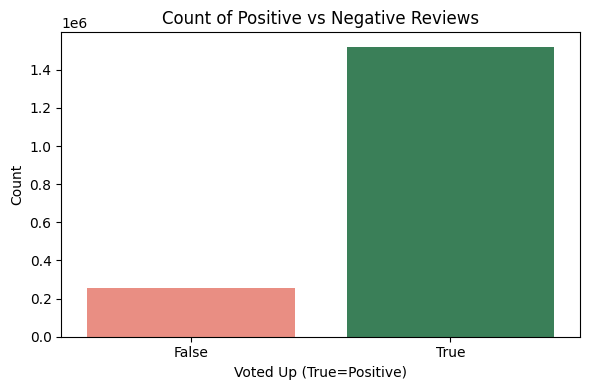

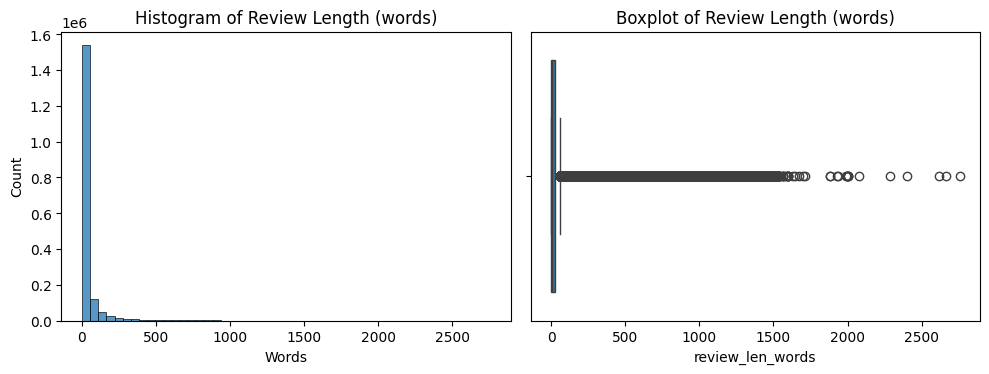

C:\Users\nbuell\AppData\Local\Temp\ipykernel_33656\3936641742.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.dropna(subset=['timestamp']).set_index('timestamp').resample('M').size()


KeyboardInterrupt: 

In [ ]:
# Basic sanity/info
print("Shape:", df.shape)
print("\nColumns and dtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum()) # test

## Sentiment Analysis
With all of our reviews loaded we can now perform sentiment analysis on the data to determine how users feel about different games.

### Inspecting Reviews
Starting off this analysis we'll see which games have the most positive and negative reviews.

In [ ]:
# Creating an empty dictionary to store reviews
review_ratios = {}

# Analyzing review sentiments
for review in all_reviews_data:
    t_app_id = review['game_appid']
    
    # Initialize the app ID entry if it doesn't exist
    if t_app_id not in review_ratios.keys():
        review_ratios[t_app_id] = {
            'rated_up': 0,
            'rated_down': 0,
            'percent_positive' : 0.0
        }

        # Map the app ID to its name
        review_ratios[t_app_id]['name'] = app_id_to_name_map[int(t_app_id)]

    # Increment the appropriate counter based on the review sentiment
    if review['voted_up']:
        review_ratios[t_app_id]['rated_up'] += 1
    else:
        review_ratios[t_app_id]['rated_down'] += 1

    # Calculating positive review ratios
    review_ratios[t_app_id]['percent_positive'] = (
        review_ratios[t_app_id]['rated_up'] /
        (review_ratios[t_app_id]['rated_up'] + review_ratios[t_app_id]['rated_down'])
    ) * 100.0

NameError: name 'app_id_to_name_map' is not defined

In [ ]:
# Creating a DataFrame for visualization
viz_1_df = pd.DataFrame.from_dict(review_ratios, orient='index')
viz_1_df.index.name = 'AppID'

viz_1_df['total_reviews'] = viz_1_df['rated_up'] + viz_1_df['rated_down']

metrics_to_plot = [
    'total_reviews',
    'rated_up',
    'rated_down',
    'percent_positive'
]

for metric in metrics_to_plot:
    t_viz_df = viz_1_df.copy().sort_values(by=metric, ascending=False).head(10).reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=t_viz_df,
        x='name', 
        y=metric,
        palette="viridis",
        order=t_viz_df['name'] 
    )

    plt.title(f'Top 10 Games by {metric}', fontsize=14)
    plt.xlabel('Game Name', fontsize=12)
    plt.ylabel(f'{metric} Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

KeyError: 'rated_up'

We can see that there are a lot of differences between games in terms of user sentiment. Some games have a very high percentage of positive reviews, while others have a much lower percentage.

It's difficult to see the differences in `percent_positive` values in a bar chart, so let's try a histogram to get a better sense of the distribution.

array([[<Axes: title={'center': 'percent_positive'}>]], dtype=object)

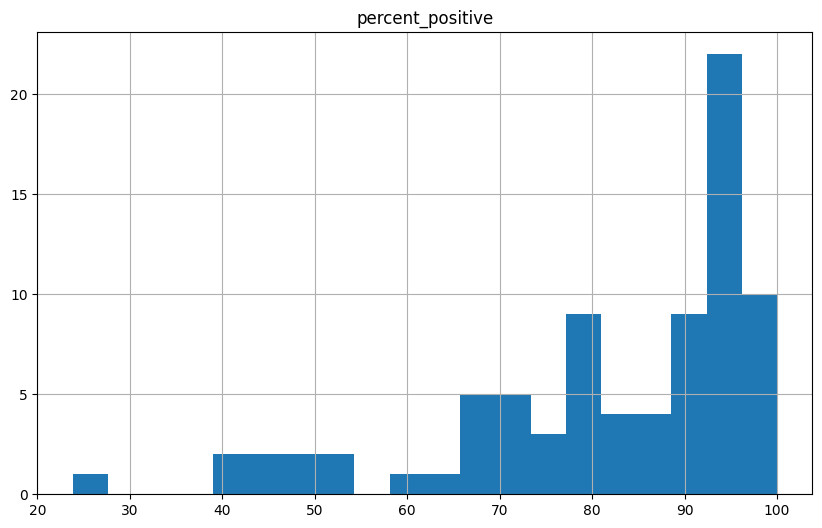

In [ ]:
viz_1_df.hist(
    column='percent_positive',
    bins=20,
    figsize=(10,6)
)

With a histogram we can see that the majority of games have a high percentage of positive reviews, with a smaller number of games having a lower percentage of positive reviews. This makes sense as it's the top 100 and the most popular games on Steam are likely to be well-liked by users.

### 4.2 Text Analysis

For this section we'll go through the text of the reviews to see what words are most commonly used in positive and negative reviews. We'll attempt to find any patterns in the words used in reviews to see if there are any common themes among positive and negative reviews.

In [ ]:
# Preparing review text data for analysis
review_text = []

# Extracting relevant fields from each review
for review in all_reviews_data:
    # Append a tuple of (App ID, Sentiment, Review Text)
    review_text.append(
        (
            review['game_appid'],
            1 if review['voted_up'] else 0,
            review['review']
        )
    )

# Summary of collected reviews
print(f"There are {len(review_text):,} reviews collected for text analysis.")

There are 1,774,962 reviews collected for text analysis.


#### 4.2.1 Getting Document Frequency

In [ ]:
# Function to clean review text
def clean_text(text):
    # Prepare stop words
    stop_words = set(stopwords.words('english'))

    # Remove non-alphabetic characters and convert to lower case
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    
    # Tokenize the text
    filtered_words = [
        word for word in word_tokenize(text) 
        if word.isalpha() and word not in stop_words
    ]

    return filtered_words

# Separate positive and negative reviews and clean the text
positive_reviews = clean_text(' '.join([text for appid, sentiment, text in review_text if sentiment == 1]))
negative_reviews = clean_text(' '.join([text for appid, sentiment, text in review_text if sentiment == 0]))



In [ ]:
# # Calculate document frequency for positive reviews
positive_reviews_dict = {}
for word in positive_reviews:
    if word in positive_reviews_dict:
        positive_reviews_dict[word] += 1
    else:
        positive_reviews_dict[word] = 1

pos_df = pd.DataFrame.from_dict(positive_reviews_dict, orient='index', columns=['doc_frequency'])
pos_df = pos_df.sort_values(by='doc_frequency', ascending=False)

# Calculate document frequency for negative reviews
negative_reviews_dict = {}
for word in negative_reviews:
    if word in negative_reviews_dict:
        negative_reviews_dict[word] += 1
    else:
        negative_reviews_dict[word] = 1

neg_df = pd.DataFrame.from_dict(negative_reviews_dict, orient='index', columns=['doc_frequency'])
neg_df = neg_df.sort_values(by='doc_frequency', ascending=False)

In [ ]:
pos_df.head()

,doc_frequency
game,1040656
good,271573
fun,268791
like,216564
play,159039


In [ ]:
neg_df.head()

,doc_frequency
game,373741
like,96985
play,68373
get,62284
even,61623


From the above, we can see that there are a few common words in both positive and negative reviews such as "game" and "play". However, there are also some words that are more common in positive reviews such as "good",  and "fun".

To try to visualize the differences better, we'll try to remove any common words in the top 1000 words across both positive and negative reviews. This will help us to see the differences in the words used in positive and negative reviews more clearly.

With this data, we'll generate word clouds to visualize the most common words in positive and negative reviews.

### 4.2.2 Generating Word Clouds

In [ ]:
# Removing common words in the top 1000 across both positive and negative reviews
filtered_pos_df = pos_df[~pos_df.index.isin(neg_df.head(1000).index)]
filtered_neg_df = neg_df[~neg_df.index.isin(pos_df.head(1000).index)]

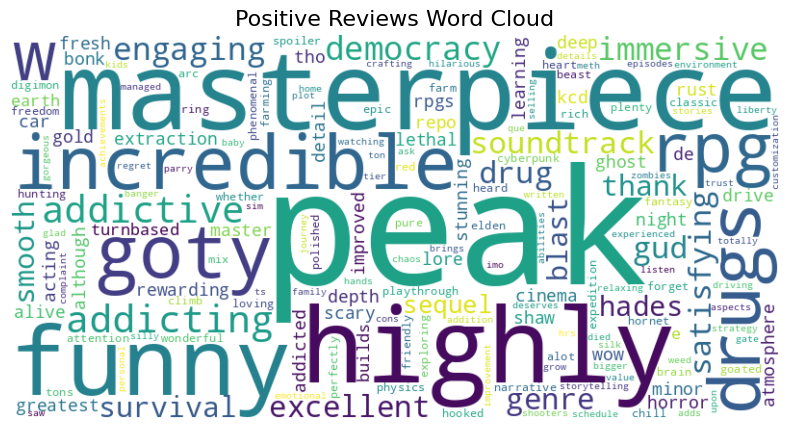

In [ ]:
# Configuration settings
wc_config = dict(
    width=800, 
    height=400, 
    background_color='white', 
    min_font_size=10
)

# Generate the word cloud directly from the frequency dictionary
wordcloud = WordCloud(**wc_config).generate_from_frequencies(filtered_pos_df.to_dict()['doc_frequency'])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud', fontsize=16)
plt.axis('off')
plt.show()

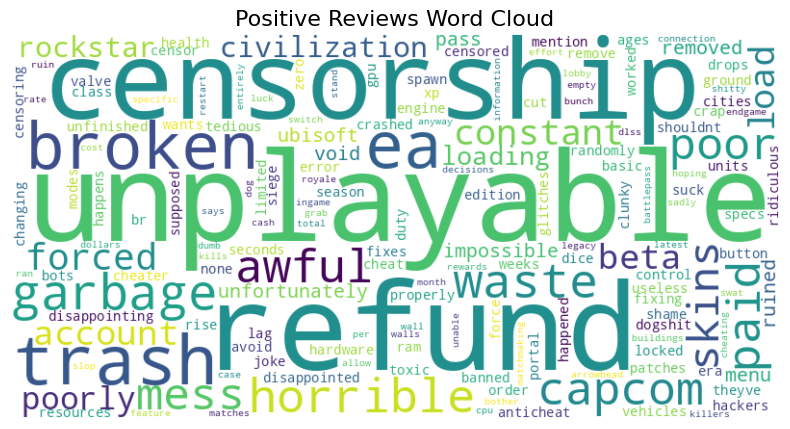

In [ ]:
# Configuration settings
wc_config = dict(
    width=800, 
    height=400, 
    background_color='white', 
    min_font_size=10
)

# Generate the word cloud directly from the frequency dictionary
wordcloud = WordCloud(**wc_config).generate_from_frequencies(filtered_neg_df.to_dict()['doc_frequency'])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud', fontsize=16)
plt.axis('off')
plt.show()

This was much more insightful. Asking for a refhund is a common theme in negative reviews, while words like "peak" and "masterpiece" are common in positive reviews. This gives us a better sense of the themes present in positive and negative reviews on Steam.

Additionally, we can see in the negative reviews that there's a theme of added costs such as "skins" and "paid", assumingly referring to in-game purchases that users are unhappy about. A quick call out as it seems that Rockstar Games titles have a lot of negative reviews, potentially due to the controversy around GTA Online and its microtransactions.

## 5. Network Analysis for Reviewers

### 5.1 Network Construction

### 5.2 Core Network Analysis